In [1]:
import tensorflow as tf
import numpy as np
import random

In [28]:
data = np.array([(x,x) for x in np.arange(10e5)],dtype=[('label','int32'),('input', 'U10')])

In [29]:
training_fraction = 0.85
train_end = int(len(data) * training_fraction)

labels, inputs = zip(*data)
train_labels, train_inputs = np.array(labels[:train_end]), np.array(inputs[:train_end])
test_labels, test_inputs = np.array(labels[train_end:]), np.array(inputs[train_end:])

In [30]:
print(np.where(train_labels == 0.0))
print(np.where(train_inputs == '0.0'))

(array([0]),)
(array([0]),)
(array([], dtype=int64),)


<ipython-input-30-416eb805b2e6>:3: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  print(np.where(data == (0.0,'0.0')))


In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))

In [32]:
train_dataset.take(1)

<TakeDataset shapes: ((), ()), types: (tf.string, tf.int32)>

In [33]:
# How much it loads into memory for sampling
BUFFER_SIZE = 100000
# Batch for gradient averaging
BATCH_SIZE = 64
# prefetch parrallelising loading + execution (not huge so not necessary)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(BATCH_SIZE*2)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(BATCH_SIZE*2)

In [34]:
sample, label = next(iter(train_dataset.take(1)))
print(sample, label)

tf.Tensor(
[b'79355.0' b'46193.0' b'49303.0' b'63600.0' b'27182.0' b'12455.0'
 b'1300.0' b'20993.0' b'67096.0' b'73306.0' b'43535.0' b'27926.0'
 b'94576.0' b'65195.0' b'29584.0' b'15386.0' b'58952.0' b'51546.0'
 b'93976.0' b'89059.0' b'97591.0' b'40263.0' b'50895.0' b'80269.0'
 b'76194.0' b'41752.0' b'43663.0' b'75615.0' b'94185.0' b'9782.0'
 b'90570.0' b'8051.0' b'80433.0' b'16938.0' b'17964.0' b'41786.0'
 b'30596.0' b'89461.0' b'34655.0' b'82285.0' b'97534.0' b'16609.0'
 b'51878.0' b'56155.0' b'39104.0' b'96685.0' b'20444.0' b'7612.0'
 b'91508.0' b'23128.0' b'72313.0' b'43525.0' b'57920.0' b'99315.0'
 b'6761.0' b'98183.0' b'25447.0' b'26263.0' b'41064.0' b'93616.0'
 b'59610.0' b'36805.0' b'65623.0' b'60591.0'], shape=(64,), dtype=string) tf.Tensor(
[79355 46193 49303 63600 27182 12455  1300 20993 67096 73306 43535 27926
 94576 65195 29584 15386 58952 51546 93976 89059 97591 40263 50895 80269
 76194 41752 43663 75615 94185  9782 90570  8051 80433 16938 17964 41786
 30596 89461 34655 8

In [43]:
def standardize(batch):
    '''
    Designed to seperate digits in number
    '''
    DEFAULT_REGEX = r'[!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']'
    # Remove any pennies/cents
    batch = tf.strings.regex_replace(batch, r'([\.|,][0-9].*)', '')
    # Normal punc strip
    batch = tf.strings.regex_replace(batch, DEFAULT_REGEX, "")
    # Spread out the values so we can get them frequent enough to appear in our vocab
    batch = tf.strings.regex_replace(batch, r'([0-9])', r'\1 ')
    return batch

VOCAB_SIZE = 10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize=standardize, ngrams=(1,)
)


In [44]:
encoder.adapt(train_dataset.map(lambda text, label: text))

In [45]:
encoded_sample = encoder(sample).numpy()[:3]
print(encoded_sample)

[[ 6 10  3  8  8]
 [ 2  7  5 10  3]
 [ 2 10  3 11  3]]


In [46]:
vocab = np.array(encoder.get_vocabulary())
for n in range(3):
  print("Original: ", sample[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_sample[n]]))
  print()

Original:  b'79355.0'
Round-trip:  7 9 3 5 5

Original:  b'46193.0'
Round-trip:  4 6 1 9 3

Original:  b'49303.0'
Round-trip:  4 9 3 0 3



In [59]:
model = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
)

In [67]:
history = model.fit(
    train_dataset, epochs=1, validation_steps=30, validation_data=test_dataset
)

13282/13282 [==============================] - 139s 10ms/step - loss: 7352290.0000 - val_loss: 19422340.0000


In [68]:
res = model.evaluate(test_dataset)

2344/2344 [==============================] - 9s 4ms/step - loss: 17154484224.0000


In [ ]:
long_model = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

long_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
)

history = long_model.fit(
    train_dataset, epochs=50, validation_steps=30, validation_data=test_dataset
)

long_res = long_model.evaluate(test_dataset)

Epoch 1/50
13282/13282 [==============================] - 145s 11ms/step - loss: 47187673088.0000 - val_loss: 70932611072.0000
Epoch 2/50
13282/13282 [==============================] - 140s 11ms/step - loss: 1471384448.0000 - val_loss: 76223144.0000
Epoch 3/50
11118/13282 [========================>.....] - ETA: 22s - loss: 36046752.0000

In [ ]:
sample_text = '9001234761'
predictions = model.predict(np.array([sample_text]))
predictions

In [70]:
sample_text = 'asd'
predictions = model.predict(np.array([sample_text]))
predictions

array([[238.6538]], dtype=float32)

In [71]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_" + metric])

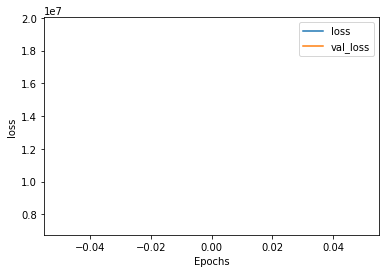

In [72]:
plot_graphs(history,'loss')